## Importing Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import lightning.pytorch as pl
from torchsummary import summary
from torchmetrics import Accuracy
import itertools
import random
print(torch.__version__)

2.0.1


## Hyperparameters

In [2]:
learning_rate = 1e-02
batch_size = 256
epochs = 40
img_size = (33,33)
train_size = 0.8
num_classes = 1000

## Downloading and Loading Data

In [3]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, permutations, transforms = None):
        self.images = images
        self.transforms = transforms
        self.permutations = permutations

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms:
            img = self.transforms(img)
        orig_img = img
        # Generating patches
        patches = []
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            patches.append(orig_img[:, row_start:row_end, col_start:col_end])
        perm_idx = np.random.randint(len(self.permutations))
        perm = self.permutations[perm_idx]
        patches = [patches[idx] for idx in perm]
        permuted_img = np.zeros_like(orig_img)
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            permuted_img[:, row_start:row_end, col_start:col_end] = patches[i]
            patches[i] = patches[i].unsqueeze(0)

        patches = torch.cat(patches, 0)
        return orig_img, permuted_img, patches, perm_idx

In [4]:
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=None)
all_permutations = list(itertools.permutations([0,1,2,3,4,5,6,7,8]))
random.shuffle(all_permutations)
all_permutations = all_permutations[:num_classes] # Selecting 1000 random permutations
cifar10_test = datasets.CIFAR10('./data', train=False)

In [5]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

all_idxs = np.arange(len(cifar10_train))
random.shuffle(all_idxs)
train_idxs = all_idxs[:int(train_size*len(all_idxs))]
valid_idxs = all_idxs[int(train_size*len(all_idxs)):]


train_dataset = Cifar10Dataset(cifar10_train.data[train_idxs], all_permutations, train_transforms)
valid_dataset = Cifar10Dataset(cifar10_train.data[valid_idxs], all_permutations, valid_transforms)
test_dataset = Cifar10Dataset(cifar10_test.data, all_permutations, test_transforms)
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Visualizing Data

In [6]:
def images_visualization(orig_images, permuted_image, title1, title2):
    fig, axes = plt.subplots(nrows=8, ncols=17, figsize=(17,8))
    orig_images = orig_images[:64]
    permuted_image = permuted_image[:64]
    for idx, (img1, img2) in enumerate(zip(orig_images, permuted_image)):
        row_num = idx // 8
        col_num1 = idx % 8
        col_num2 = idx % 8 + 9

        # Display the first set of kernels
        if img1.ndim == 3:
            axes[row_num][col_num1].imshow(img1.permute(1,2,0))
        else:
            axes[row_num][col_num1].imshow(img1, cmap = 'gray')
        axes[row_num][col_num1].axis('off')
        
        # Display the second set of kernels
        if img2.ndim == 3:
            axes[row_num][col_num2].imshow(img2.permute(1,2,0))
        else:
            axes[row_num][col_num2].imshow(img2, cmap = 'gray')
        axes[row_num][col_num2].axis('off')

    for row_num in range(8):
        axes[row_num][8].axis('off')
        
    # Add titles for the first and second set of kernels
    axes[0][3].set_title(title1,fontsize=20)
    axes[0][12].set_title(title2,fontsize=20)

    plt.tight_layout()
    plt.show()

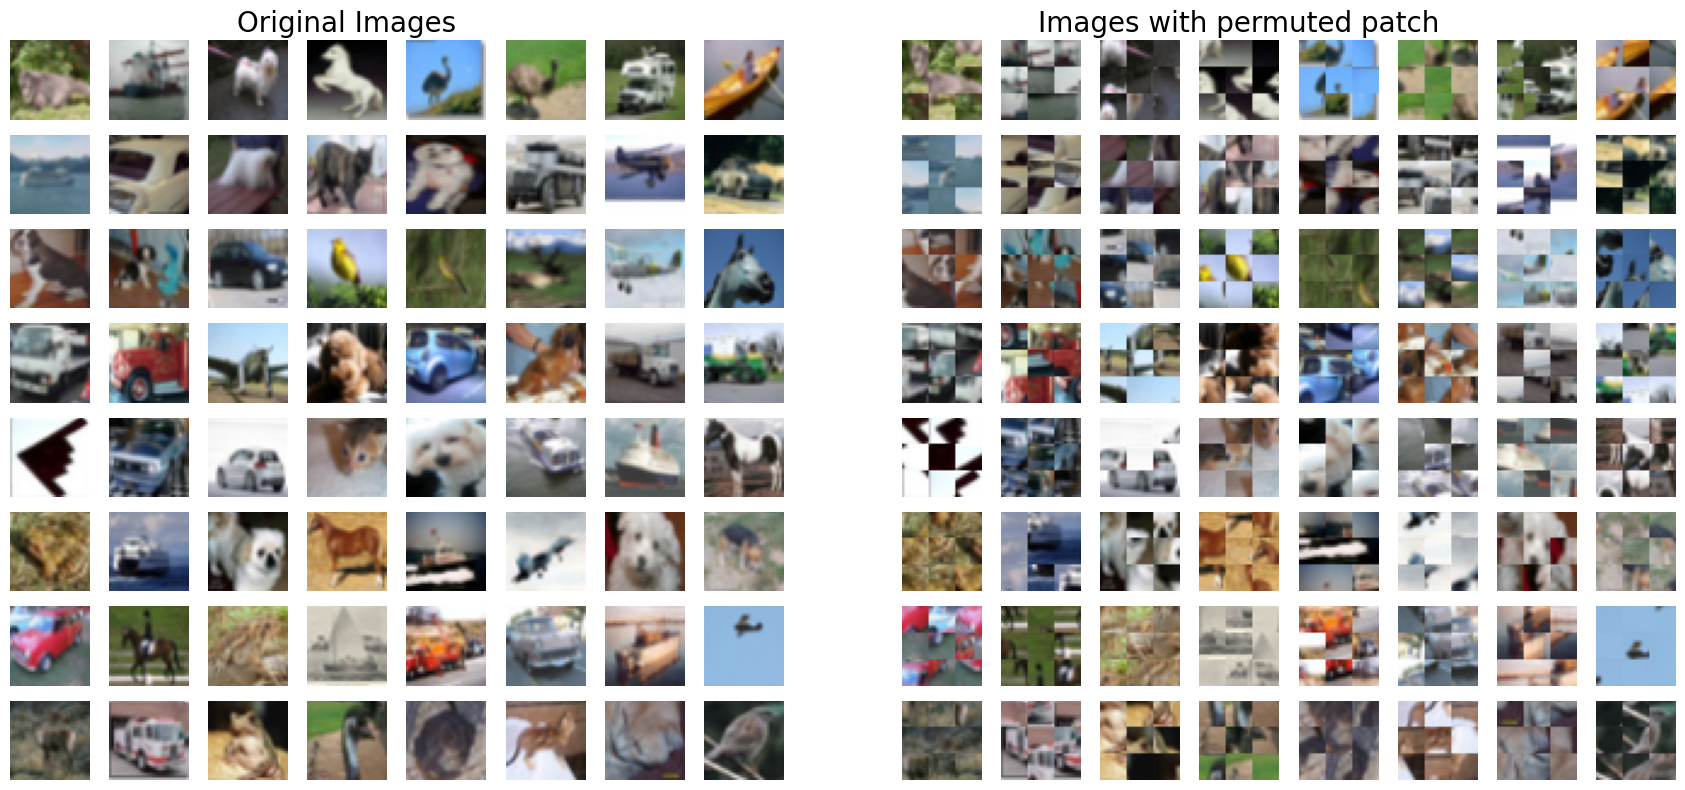

In [7]:
orig_img, permuted_img, patches, perm_idx = next(iter(trainloader))
images_visualization(orig_img, permuted_img, "Original Images", "Images with permuted patch")

## Model Building


In [8]:
class JigsawModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.generate_model(num_classes)
        self.loss_fxn()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        loss = self.criterion(preds, perm_idx)
        train_acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, patches, perm_idx = batch
        preds = self(patches)
        val_loss = self.criterion(preds, perm_idx)
        val_acc = self.accuracy(preds, perm_idx)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-02)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()

    def generate_model(self, num_classes):
        self.featureExtractor = nn.Sequential(self.conv_block(3, 32, 3, 1, 1),
                                              self.conv_block(32, 64, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(64, 64, 3, 1, 1),
                                              self.conv_block(64, 128, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(128, 128, 3, 1, 1),
                                              self.conv_block(128, 256, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Flatten()
                                              )
        self.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(256*9, 2048), # 9 since that is the number of patches
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, num_classes)
                                   )
        self.output.apply(self.init_weights)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.ReLU(inplace=True),
                            )
        block.apply(self.init_weights)
        return block

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, x):
        batch, patches, channels, height, width = x.shape
        x = x.transpose(0,1)
        features = []
        for patch_idx in range(patches):
            curr_patch = x[patch_idx]
            curr_patch_features = self.featureExtractor(curr_patch)
            features.append(curr_patch_features)

        features = torch.cat(features, dim = -1)
        out = self.output(features)
        return out

## Training the model

In [ ]:
torch.set_float32_matmul_precision('medium')
jigsaw_model = JigsawModel(len(all_permutations))
trainer = pl.Trainer(max_epochs = epochs, log_every_n_steps=10)
trainer.fit(jigsaw_model, trainloader, validloader)

In [11]:
metric = pd.read_csv('lightning_logs/version_0/metrics.csv')
metric.head()

,Valid_loss,valid_acc,step,epoch,Train_loss,train_acc
0,6.843129,0.0039,156,0,NaN,NaN
1,NaN,NaN,156,0,7.851801,0.002025
2,6.358162,0.0233,313,1,NaN,NaN
3,NaN,NaN,313,1,6.557720,0.013850
4,5.299727,0.0716,470,2,NaN,NaN


In [15]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss'].isna()]['Train_loss'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc'].isna()]['train_acc'].values

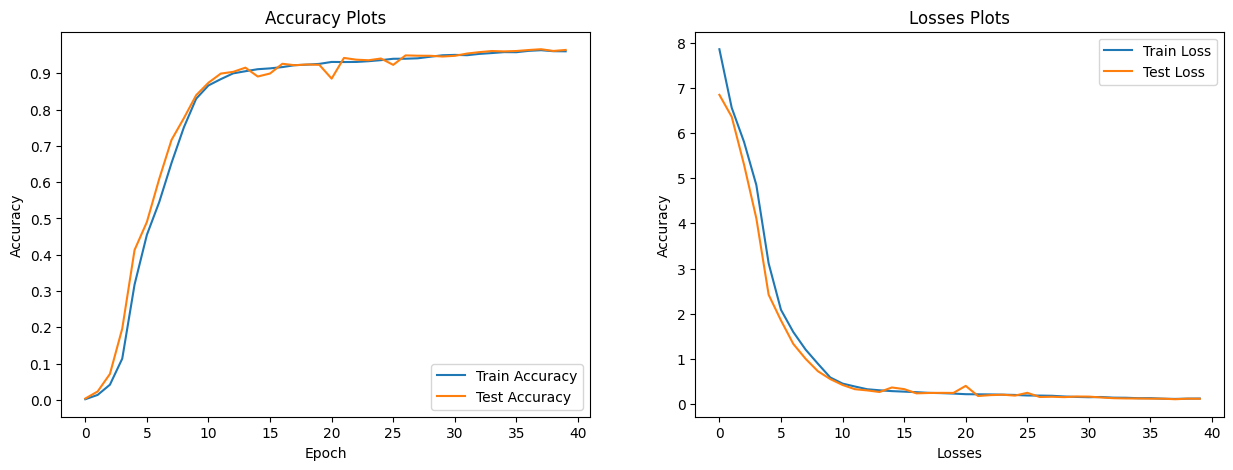

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(valid_accuracy, label="Test Accuracy")
axes[0].set_title('Accuracy Plots')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(valid_losses, label="Test Loss")
axes[1].set_title('Losses Plots')
axes[1].set_xlabel('Losses')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## Final Results

In [17]:
def rejumble_jigsaw(patches, perm_idx):
    current_perm = all_permutations[perm_idx]
    rejumbled_img = torch.zeros((3,33,33))
    for i in range(9):
        row, col = current_perm[i]//3, current_perm[i]%3
        row_start, row_end = row*11, row*11+11
        col_start, col_end = col*11, col*11+11
        rejumbled_img[:, row_start:row_end, col_start:col_end] = patches[i].detach().cpu()
    return rejumbled_img

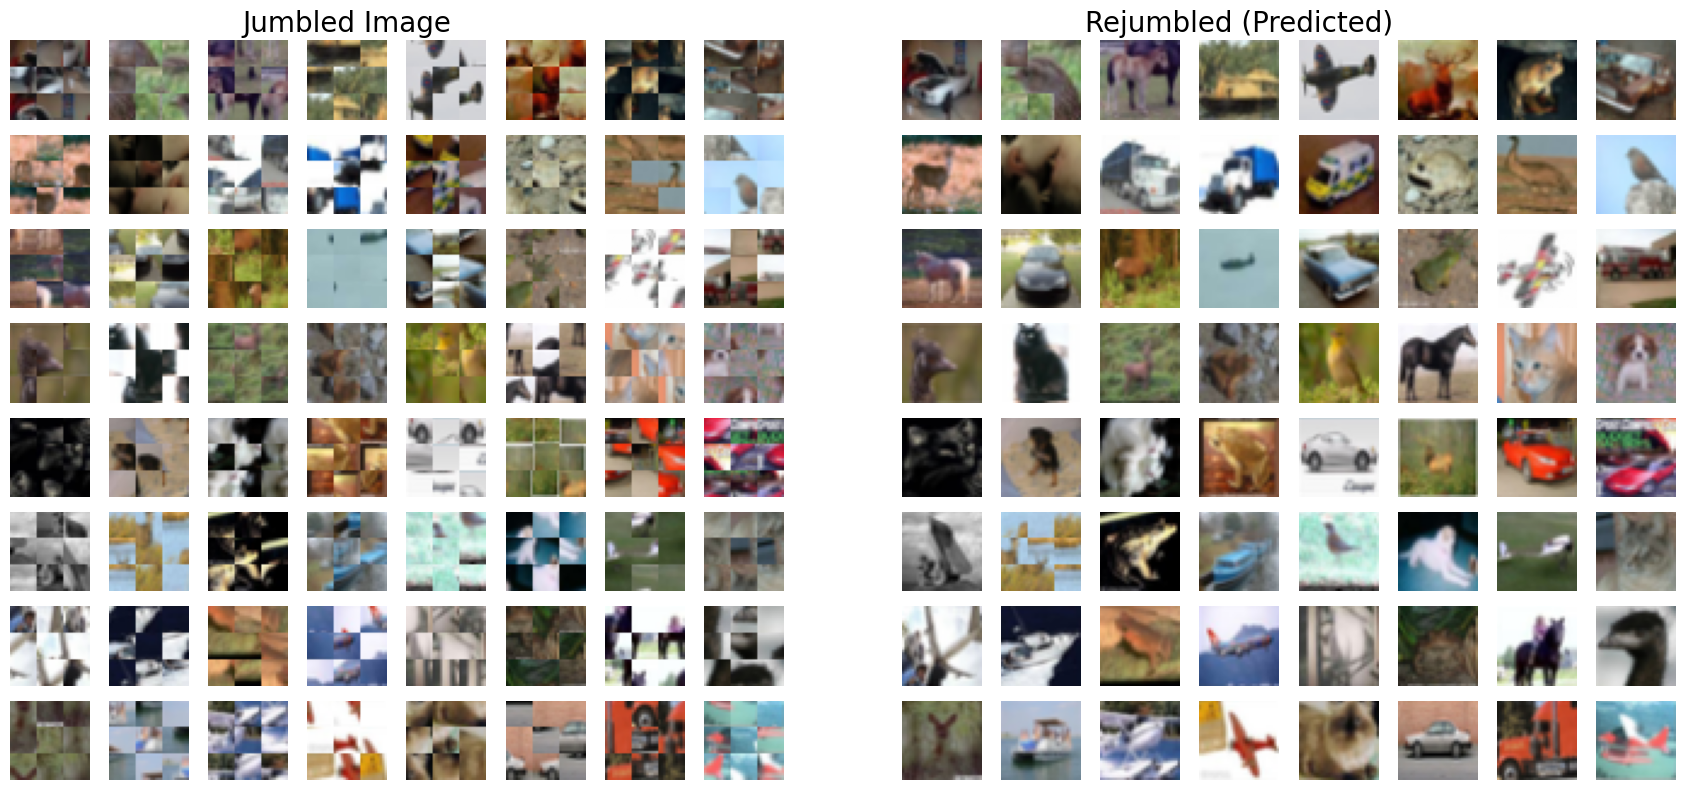

In [18]:
orig_img, permuted_img, patches, perm_idx = next(iter(validloader))
predictions = torch.max(jigsaw_model(patches), axis = -1)[1]
rejumbled_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    rejumbled_images[i] = rejumble_jigsaw(patches[i], predictions[i])
images_visualization(permuted_img, rejumbled_images, 'Jumbled Image', 'Rejumbled (Predicted)')

## Conclusion